In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import xgboost as xgb
from preprocess import preprocess_data
from feature_engineer import add_combined_mean_prop_features, add_features, add_normalised_prop_features
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm
import datetime
import xgboost as xgb

In [2]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
tqdm.pandas()

In [3]:
start = time.time()
df_train = pd.read_csv("raw_data/train_data.csv", parse_dates=[1])
df_test = pd.read_csv("raw_data/test_data.csv", parse_dates=[1])
end = time.time()
print("Data loaded in ", end - start, " seconds.")

Data loaded in  23.083402633666992  seconds.


In [4]:
rates = pd.read_csv("preprocessed_data/df_rates.csv")
rates['prop_id'] = rates['prop_id'].astype(int)

In [ ]:
df_train.head(1)

In [ ]:
df_test.head(1)

## Preprocess Data

In [5]:
start = time.time()
preprocessed_train = preprocess_data(df_train, split='train')
print('------')
preprocessed_test = preprocess_data(df_test, split='test')
end = time.time()
print("Data preprocessing took ", end - start, " seconds.")

Done imputing
------
Done imputing
Data preprocessing took  5.815262079238892  seconds.


In [ ]:
preprocessed_train.head(1)

In [ ]:
preprocessed_test.head(1)

## Adding and Dropping Features

In [6]:
preprocessed_train = add_normalised_prop_features(preprocessed_train)
preprocessed_test = add_normalised_prop_features(preprocessed_test)

In [7]:
preprocessed_train, preprocessed_test = add_combined_mean_prop_features(preprocessed_train, preprocessed_test)

Adding mean, median and std of:  prop_starrating
Adding mean, median and std of:  prop_review_score
Adding mean, median and std of:  prop_log_historical_price
Adding mean, median and std of:  prop_location_score1
Adding mean, median and std of:  prop_location_score2


In [8]:
drop_columns = ['date_time', 'srch_query_affinity_score', 'orig_destination_distance']
preprocessed_train.drop(columns=drop_columns, inplace=True)
preprocessed_test.drop(columns=drop_columns, inplace=True)

In [9]:
print('Features Used')
preprocessed_test.isnull().sum()

Features Used


srch_id                            0
site_id                            0
visitor_location_country_id        0
prop_country_id                    0
prop_id                            0
prop_starrating                    0
prop_review_score                  0
prop_brand_bool                    0
prop_location_score1               0
prop_location_score2               0
prop_log_historical_price          0
price_usd                          0
promotion_flag                     0
srch_destination_id                0
srch_length_of_stay                0
srch_booking_window                0
srch_adults_count                  0
srch_children_count                0
srch_room_count                    0
srch_saturday_night_bool           0
random_bool                        0
price_usd_mean                     0
meanprop_starrating                0
medianprop_starrating              0
stdprop_starrating                 0
meanprop_review_score              0
medianprop_review_score            0
s

## Make Relevance Targets

Create a column called score which would be 
df['score'] = 4 * df.booking_bool + df.click_bool

In [10]:
preprocessed_train['rel'] = 4 * preprocessed_train.booking_bool + preprocessed_train.click_bool

In [11]:
X = preprocessed_train.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'], axis=1)

In [12]:
X_rand_false = X[X['random_bool']==0]
X_rand_true = X[X['random_bool']==1]

In [13]:
print(f'num_features:{X.shape[1]-2}') # -2 as we donot use srch_id and rel

num_features:36


In [ ]:
X.head(1)

# Train Test Split

In [36]:
def train(X_train, y_train, train_groups, X_val=None, y_val=None, eval_groups=None):

    model = xgb.XGBRanker(  
        tree_method='gpu_hist',
        booster='gbtree',
        objective='rank:ndcg',
        random_state=42, 
        learning_rate=0.1,
        colsample_bytree=0.8, 
        eta=0.05, 
        max_depth=6, 
        n_estimators=500, 
        subsample=0.8,
        predictor='gpu_predictor'
        )
    
    if X_val is None:
        model = model.fit(X_train, y_train, group=train_groups, eval_set=[(X_train, y_train)], 
              eval_group = [train_groups], eval_metric='ndcg@5', verbose=True, early_stopping_rounds=20)
    else:
        model = model.fit(X_train, y_train, group=train_groups, eval_set=[(X_val, y_val), (X_train, y_train)], 
              eval_group = [eval_groups, train_groups], eval_metric='ndcg@5', verbose=True, early_stopping_rounds=20)

    
    return model
    

In [15]:
def get_cross_val_splits(df_train, train_inds, val_inds):
    train_data= df_train.iloc[train_inds]
    X_train = train_data.loc[:, ~train_data.columns.isin(['srch_id','rel'])]
    y_train = train_data.loc[:, train_data.columns.isin(['rel'])]
    train_groups = train_data.groupby('srch_id').size().to_frame('size')['size'].to_numpy()
    
    val_data= df_train.iloc[val_inds]
    #We need to keep the id for later predictions
    X_val = val_data.loc[:, ~val_data.columns.isin(['srch_id','rel'])]
    X_val_with_srch_id = val_data.loc[:, ~val_data.columns.isin(['rel'])]
    y_val = val_data.loc[:, val_data.columns.isin(['rel'])]
    eval_groups = X_val_with_srch_id.groupby('srch_id').size().to_frame('size')['size'].to_numpy()
    
    return X_train, y_train, train_groups, X_val, y_val, eval_groups 

## Run Cross Validation

In [ ]:
gss = GroupShuffleSplit(test_size=0.1, n_splits=5, random_state = 7)
best_model = None
best_ndcg = 0
cross_val_score = []
for idx, (train_inds, val_inds) in enumerate(gss.split(X, groups=X['srch_id'])):
    X_train, y_train, train_groups, X_val, y_val, eval_groups = get_cross_val_splits(X, train_inds, val_inds)
    
    print(f'Training on fold:{idx}')
    model = train(X_train, y_train, train_groups, X_val, y_val, eval_groups)
    res_ndcg = model.evals_result()
    res_ndcg = res_ndcg['validation_0']['ndcg@5'][-1]
    cross_val_score.append(res_ndcg)
    if res_ndcg > 0:
        best_ndcg = res_ndcg
        best_model = model
    print('fold:'+str(idx)+' ndcg@5 ', res_ndcg)

print('cross validation performance:', sum(cross_val_score)/len(cross_val_score))
    


## Run model on full train data

In [32]:
X = X_rand_false

In [33]:
X_train = X.loc[:, ~X.columns.isin(['srch_id','rel'])]
y_train = X.loc[:, X.columns.isin(['rel'])]
train_groups = X.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

In [34]:
model = train(X_train, y_train, train_groups)

[0]	validation_0-ndcg@5:0.29079
[1]	validation_0-ndcg@5:0.30719
[2]	validation_0-ndcg@5:0.32142
[3]	validation_0-ndcg@5:0.32358
[4]	validation_0-ndcg@5:0.32530
[5]	validation_0-ndcg@5:0.32517
[6]	validation_0-ndcg@5:0.33001
[7]	validation_0-ndcg@5:0.33121
[8]	validation_0-ndcg@5:0.33231
[9]	validation_0-ndcg@5:0.33432
[10]	validation_0-ndcg@5:0.33498
[11]	validation_0-ndcg@5:0.34062
[12]	validation_0-ndcg@5:0.34248
[13]	validation_0-ndcg@5:0.34239
[14]	validation_0-ndcg@5:0.34379
[15]	validation_0-ndcg@5:0.34378
[16]	validation_0-ndcg@5:0.34460
[17]	validation_0-ndcg@5:0.34563
[18]	validation_0-ndcg@5:0.34716
[19]	validation_0-ndcg@5:0.34908
[20]	validation_0-ndcg@5:0.35002
[21]	validation_0-ndcg@5:0.35029
[22]	validation_0-ndcg@5:0.35086
[23]	validation_0-ndcg@5:0.35080
[24]	validation_0-ndcg@5:0.35081
[25]	validation_0-ndcg@5:0.35279
[26]	validation_0-ndcg@5:0.35485
[27]	validation_0-ndcg@5:0.35476
[28]	validation_0-ndcg@5:0.35580
[29]	validation_0-ndcg@5:0.35713
[30]	validation_0-nd

[244]	validation_0-ndcg@5:0.41544
[245]	validation_0-ndcg@5:0.41552
[246]	validation_0-ndcg@5:0.41559
[247]	validation_0-ndcg@5:0.41569
[248]	validation_0-ndcg@5:0.41575
[249]	validation_0-ndcg@5:0.41580
[250]	validation_0-ndcg@5:0.41590
[251]	validation_0-ndcg@5:0.41587
[252]	validation_0-ndcg@5:0.41599
[253]	validation_0-ndcg@5:0.41607
[254]	validation_0-ndcg@5:0.41630
[255]	validation_0-ndcg@5:0.41643
[256]	validation_0-ndcg@5:0.41666
[257]	validation_0-ndcg@5:0.41674
[258]	validation_0-ndcg@5:0.41682
[259]	validation_0-ndcg@5:0.41700
[260]	validation_0-ndcg@5:0.41710
[261]	validation_0-ndcg@5:0.41717
[262]	validation_0-ndcg@5:0.41718
[263]	validation_0-ndcg@5:0.41725
[264]	validation_0-ndcg@5:0.41733
[265]	validation_0-ndcg@5:0.41745
[266]	validation_0-ndcg@5:0.41749
[267]	validation_0-ndcg@5:0.41761
[268]	validation_0-ndcg@5:0.41772
[269]	validation_0-ndcg@5:0.41771
[270]	validation_0-ndcg@5:0.41784
[271]	validation_0-ndcg@5:0.41794
[272]	validation_0-ndcg@5:0.41796
[273]	validati

[485]	validation_0-ndcg@5:0.43167
[486]	validation_0-ndcg@5:0.43169
[487]	validation_0-ndcg@5:0.43174
[488]	validation_0-ndcg@5:0.43187
[489]	validation_0-ndcg@5:0.43192
[490]	validation_0-ndcg@5:0.43194
[491]	validation_0-ndcg@5:0.43194
[492]	validation_0-ndcg@5:0.43198
[493]	validation_0-ndcg@5:0.43210
[494]	validation_0-ndcg@5:0.43215
[495]	validation_0-ndcg@5:0.43219
[496]	validation_0-ndcg@5:0.43215
[497]	validation_0-ndcg@5:0.43216
[498]	validation_0-ndcg@5:0.43221
[499]	validation_0-ndcg@5:0.43229


## Experimental

In [23]:
gss = GroupShuffleSplit(test_size=0.1, n_splits=1, random_state = 7).split(X_rand_false, groups=X_rand_false['srch_id'])
X_train_inds, X_val_inds = next(gss)
X_train = X_rand_false.iloc[X_train_inds]
X_train_data = X_train.loc[:, ~X_train.columns.isin(['srch_id','rel'])]
y_train_data = X_train.loc[:, X_train.columns.isin(['rel'])]
train_groups = X_train.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

In [24]:
X_val = X_rand_false.iloc[X_val_inds]
X_val_concat = pd.concat([X_val, X_rand_true])
X_val_data = X_val_concat.loc[:, ~X_val_concat.columns.isin(['srch_id','rel'])]
y_val_data = X_val_concat.loc[:, X_val_concat.columns.isin(['rel'])]
eval_groups = X_val_concat.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

In [25]:
X_val_rand = X_rand_true.loc[:, ~X_rand_true.columns.isin(['srch_id','rel'])]
y_val_rand = X_rand_true.loc[:, X_rand_true.columns.isin(['rel'])]
eval_groups_rand = X_rand_true.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

In [21]:
#model = train(X_train_data, y_train_data, train_groups, X_val_data, y_val_data, eval_groups)

[0]	validation_0-ndcg@5:0.43038	validation_1-ndcg@5:0.29305
[1]	validation_0-ndcg@5:0.43800	validation_1-ndcg@5:0.30960
[2]	validation_0-ndcg@5:0.44239	validation_1-ndcg@5:0.32319
[3]	validation_0-ndcg@5:0.44295	validation_1-ndcg@5:0.32458
[4]	validation_0-ndcg@5:0.44466	validation_1-ndcg@5:0.32669
[5]	validation_0-ndcg@5:0.44511	validation_1-ndcg@5:0.32799
[6]	validation_0-ndcg@5:0.44699	validation_1-ndcg@5:0.33295
[7]	validation_0-ndcg@5:0.44743	validation_1-ndcg@5:0.33453
[8]	validation_0-ndcg@5:0.44750	validation_1-ndcg@5:0.33480
[9]	validation_0-ndcg@5:0.44829	validation_1-ndcg@5:0.33621
[10]	validation_0-ndcg@5:0.44836	validation_1-ndcg@5:0.33677
[11]	validation_0-ndcg@5:0.45088	validation_1-ndcg@5:0.34248
[12]	validation_0-ndcg@5:0.45172	validation_1-ndcg@5:0.34440
[13]	validation_0-ndcg@5:0.45157	validation_1-ndcg@5:0.34430
[14]	validation_0-ndcg@5:0.45141	validation_1-ndcg@5:0.34429
[15]	validation_0-ndcg@5:0.45153	validation_1-ndcg@5:0.34435
[16]	validation_0-ndcg@5:0.45229	v

[134]	validation_0-ndcg@5:0.47285	validation_1-ndcg@5:0.40307
[135]	validation_0-ndcg@5:0.47285	validation_1-ndcg@5:0.40337
[136]	validation_0-ndcg@5:0.47297	validation_1-ndcg@5:0.40352
[137]	validation_0-ndcg@5:0.47298	validation_1-ndcg@5:0.40364
[138]	validation_0-ndcg@5:0.47292	validation_1-ndcg@5:0.40397
[139]	validation_0-ndcg@5:0.47289	validation_1-ndcg@5:0.40409
[140]	validation_0-ndcg@5:0.47294	validation_1-ndcg@5:0.40421
[141]	validation_0-ndcg@5:0.47288	validation_1-ndcg@5:0.40432
[142]	validation_0-ndcg@5:0.47291	validation_1-ndcg@5:0.40443
[143]	validation_0-ndcg@5:0.47289	validation_1-ndcg@5:0.40459
[144]	validation_0-ndcg@5:0.47301	validation_1-ndcg@5:0.40480
[145]	validation_0-ndcg@5:0.47310	validation_1-ndcg@5:0.40497
[146]	validation_0-ndcg@5:0.47319	validation_1-ndcg@5:0.40522
[147]	validation_0-ndcg@5:0.47306	validation_1-ndcg@5:0.40543
[148]	validation_0-ndcg@5:0.47308	validation_1-ndcg@5:0.40558
[149]	validation_0-ndcg@5:0.47312	validation_1-ndcg@5:0.40572
[150]	va

[267]	validation_0-ndcg@5:0.47605	validation_1-ndcg@5:0.41889
[268]	validation_0-ndcg@5:0.47608	validation_1-ndcg@5:0.41898
[269]	validation_0-ndcg@5:0.47604	validation_1-ndcg@5:0.41913
[270]	validation_0-ndcg@5:0.47603	validation_1-ndcg@5:0.41916
[271]	validation_0-ndcg@5:0.47612	validation_1-ndcg@5:0.41934
[272]	validation_0-ndcg@5:0.47617	validation_1-ndcg@5:0.41940
[273]	validation_0-ndcg@5:0.47611	validation_1-ndcg@5:0.41951
[274]	validation_0-ndcg@5:0.47606	validation_1-ndcg@5:0.41950
[275]	validation_0-ndcg@5:0.47612	validation_1-ndcg@5:0.41953
[276]	validation_0-ndcg@5:0.47613	validation_1-ndcg@5:0.41964
[277]	validation_0-ndcg@5:0.47624	validation_1-ndcg@5:0.41979
[278]	validation_0-ndcg@5:0.47629	validation_1-ndcg@5:0.41985
[279]	validation_0-ndcg@5:0.47634	validation_1-ndcg@5:0.41992
[280]	validation_0-ndcg@5:0.47635	validation_1-ndcg@5:0.42005
[281]	validation_0-ndcg@5:0.47635	validation_1-ndcg@5:0.42009
[282]	validation_0-ndcg@5:0.47630	validation_1-ndcg@5:0.42017
[283]	va

[400]	validation_0-ndcg@5:0.47768	validation_1-ndcg@5:0.42880
[401]	validation_0-ndcg@5:0.47769	validation_1-ndcg@5:0.42888
[402]	validation_0-ndcg@5:0.47772	validation_1-ndcg@5:0.42899
[403]	validation_0-ndcg@5:0.47771	validation_1-ndcg@5:0.42900
[404]	validation_0-ndcg@5:0.47765	validation_1-ndcg@5:0.42909
[405]	validation_0-ndcg@5:0.47765	validation_1-ndcg@5:0.42916
[406]	validation_0-ndcg@5:0.47764	validation_1-ndcg@5:0.42934
[407]	validation_0-ndcg@5:0.47759	validation_1-ndcg@5:0.42928
[408]	validation_0-ndcg@5:0.47763	validation_1-ndcg@5:0.42939
[409]	validation_0-ndcg@5:0.47770	validation_1-ndcg@5:0.42939
[410]	validation_0-ndcg@5:0.47770	validation_1-ndcg@5:0.42947
[411]	validation_0-ndcg@5:0.47769	validation_1-ndcg@5:0.42948
[412]	validation_0-ndcg@5:0.47770	validation_1-ndcg@5:0.42953
[413]	validation_0-ndcg@5:0.47771	validation_1-ndcg@5:0.42957
[414]	validation_0-ndcg@5:0.47772	validation_1-ndcg@5:0.42954
[415]	validation_0-ndcg@5:0.47774	validation_1-ndcg@5:0.42966
[416]	va

In [ ]:
validation_0-ndcg@5:0.33183	validation_1-ndcg@5:0.43229

In [29]:
model = xgb.XGBRanker(  
        tree_method='gpu_hist',
        booster='gbtree',
        objective='rank:ndcg',
        random_state=42, 
        learning_rate=0.1,
        colsample_bytree=0.8, 
        eta=0.05, 
        max_depth=6, 
        n_estimators=500, 
        subsample=0.8,
        predictor='gpu_predictor'
        )
    
    
model = model.fit(X_train_data, y_train_data, group=train_groups, eval_set=[(X_val_data, y_val_data), (X_val_rand, y_val_rand), (X_train_data, y_train_data)], 
              eval_group = [eval_groups, eval_groups_rand, train_groups], eval_metric='ndcg@5', verbose=True, early_stopping_rounds=20)

[0]	validation_0-ndcg@5:0.43038	validation_1-ndcg@5:0.26064	validation_2-ndcg@5:0.29305
[1]	validation_0-ndcg@5:0.43800	validation_1-ndcg@5:0.27033	validation_2-ndcg@5:0.30960
[2]	validation_0-ndcg@5:0.44239	validation_1-ndcg@5:0.27865	validation_2-ndcg@5:0.32319
[3]	validation_0-ndcg@5:0.44295	validation_1-ndcg@5:0.27913	validation_2-ndcg@5:0.32458
[4]	validation_0-ndcg@5:0.44466	validation_1-ndcg@5:0.27978	validation_2-ndcg@5:0.32669
[5]	validation_0-ndcg@5:0.44511	validation_1-ndcg@5:0.28029	validation_2-ndcg@5:0.32799
[6]	validation_0-ndcg@5:0.44699	validation_1-ndcg@5:0.28325	validation_2-ndcg@5:0.33295
[7]	validation_0-ndcg@5:0.44743	validation_1-ndcg@5:0.28410	validation_2-ndcg@5:0.33453
[8]	validation_0-ndcg@5:0.44750	validation_1-ndcg@5:0.28445	validation_2-ndcg@5:0.33480
[9]	validation_0-ndcg@5:0.44829	validation_1-ndcg@5:0.28513	validation_2-ndcg@5:0.33621
[10]	validation_0-ndcg@5:0.44836	validation_1-ndcg@5:0.28512	validation_2-ndcg@5:0.33677
[11]	validation_0-ndcg@5:0.4508

[93]	validation_0-ndcg@5:0.47103	validation_1-ndcg@5:0.32006	validation_2-ndcg@5:0.39440
[94]	validation_0-ndcg@5:0.47129	validation_1-ndcg@5:0.32032	validation_2-ndcg@5:0.39470
[95]	validation_0-ndcg@5:0.47125	validation_1-ndcg@5:0.32062	validation_2-ndcg@5:0.39513
[96]	validation_0-ndcg@5:0.47129	validation_1-ndcg@5:0.32068	validation_2-ndcg@5:0.39527
[97]	validation_0-ndcg@5:0.47140	validation_1-ndcg@5:0.32075	validation_2-ndcg@5:0.39565
[98]	validation_0-ndcg@5:0.47150	validation_1-ndcg@5:0.32080	validation_2-ndcg@5:0.39589
[99]	validation_0-ndcg@5:0.47155	validation_1-ndcg@5:0.32118	validation_2-ndcg@5:0.39613
[100]	validation_0-ndcg@5:0.47152	validation_1-ndcg@5:0.32136	validation_2-ndcg@5:0.39630
[101]	validation_0-ndcg@5:0.47173	validation_1-ndcg@5:0.32157	validation_2-ndcg@5:0.39662
[102]	validation_0-ndcg@5:0.47180	validation_1-ndcg@5:0.32175	validation_2-ndcg@5:0.39690
[103]	validation_0-ndcg@5:0.47175	validation_1-ndcg@5:0.32167	validation_2-ndcg@5:0.39712
[104]	validation_

[185]	validation_0-ndcg@5:0.47450	validation_1-ndcg@5:0.32621	validation_2-ndcg@5:0.41026
[186]	validation_0-ndcg@5:0.47452	validation_1-ndcg@5:0.32619	validation_2-ndcg@5:0.41031
[187]	validation_0-ndcg@5:0.47453	validation_1-ndcg@5:0.32632	validation_2-ndcg@5:0.41041
[188]	validation_0-ndcg@5:0.47458	validation_1-ndcg@5:0.32632	validation_2-ndcg@5:0.41056
[189]	validation_0-ndcg@5:0.47459	validation_1-ndcg@5:0.32627	validation_2-ndcg@5:0.41065
[190]	validation_0-ndcg@5:0.47457	validation_1-ndcg@5:0.32626	validation_2-ndcg@5:0.41077
[191]	validation_0-ndcg@5:0.47460	validation_1-ndcg@5:0.32637	validation_2-ndcg@5:0.41082
[192]	validation_0-ndcg@5:0.47459	validation_1-ndcg@5:0.32646	validation_2-ndcg@5:0.41084
[193]	validation_0-ndcg@5:0.47466	validation_1-ndcg@5:0.32633	validation_2-ndcg@5:0.41088
[194]	validation_0-ndcg@5:0.47460	validation_1-ndcg@5:0.32627	validation_2-ndcg@5:0.41102
[195]	validation_0-ndcg@5:0.47457	validation_1-ndcg@5:0.32625	validation_2-ndcg@5:0.41126
[196]	vali

[277]	validation_0-ndcg@5:0.47591	validation_1-ndcg@5:0.32830	validation_2-ndcg@5:0.41919
[278]	validation_0-ndcg@5:0.47598	validation_1-ndcg@5:0.32841	validation_2-ndcg@5:0.41923
[279]	validation_0-ndcg@5:0.47600	validation_1-ndcg@5:0.32834	validation_2-ndcg@5:0.41926
[280]	validation_0-ndcg@5:0.47605	validation_1-ndcg@5:0.32836	validation_2-ndcg@5:0.41939
[281]	validation_0-ndcg@5:0.47608	validation_1-ndcg@5:0.32831	validation_2-ndcg@5:0.41946
[282]	validation_0-ndcg@5:0.47615	validation_1-ndcg@5:0.32851	validation_2-ndcg@5:0.41959
[283]	validation_0-ndcg@5:0.47614	validation_1-ndcg@5:0.32845	validation_2-ndcg@5:0.41968
[284]	validation_0-ndcg@5:0.47615	validation_1-ndcg@5:0.32871	validation_2-ndcg@5:0.41973
[285]	validation_0-ndcg@5:0.47624	validation_1-ndcg@5:0.32875	validation_2-ndcg@5:0.41989
[286]	validation_0-ndcg@5:0.47618	validation_1-ndcg@5:0.32870	validation_2-ndcg@5:0.41998
[287]	validation_0-ndcg@5:0.47617	validation_1-ndcg@5:0.32877	validation_2-ndcg@5:0.42006
[288]	vali

[369]	validation_0-ndcg@5:0.47714	validation_1-ndcg@5:0.32995	validation_2-ndcg@5:0.42630
[370]	validation_0-ndcg@5:0.47725	validation_1-ndcg@5:0.33001	validation_2-ndcg@5:0.42641
[371]	validation_0-ndcg@5:0.47722	validation_1-ndcg@5:0.32998	validation_2-ndcg@5:0.42639
[372]	validation_0-ndcg@5:0.47726	validation_1-ndcg@5:0.32992	validation_2-ndcg@5:0.42642
[373]	validation_0-ndcg@5:0.47719	validation_1-ndcg@5:0.32997	validation_2-ndcg@5:0.42652
[374]	validation_0-ndcg@5:0.47726	validation_1-ndcg@5:0.33006	validation_2-ndcg@5:0.42658
[375]	validation_0-ndcg@5:0.47728	validation_1-ndcg@5:0.33009	validation_2-ndcg@5:0.42661
[376]	validation_0-ndcg@5:0.47722	validation_1-ndcg@5:0.33003	validation_2-ndcg@5:0.42667
[377]	validation_0-ndcg@5:0.47719	validation_1-ndcg@5:0.33007	validation_2-ndcg@5:0.42664
[378]	validation_0-ndcg@5:0.47720	validation_1-ndcg@5:0.33011	validation_2-ndcg@5:0.42673
[379]	validation_0-ndcg@5:0.47715	validation_1-ndcg@5:0.33007	validation_2-ndcg@5:0.42668
[380]	vali

[461]	validation_0-ndcg@5:0.47788	validation_1-ndcg@5:0.33087	validation_2-ndcg@5:0.43192
[462]	validation_0-ndcg@5:0.47791	validation_1-ndcg@5:0.33088	validation_2-ndcg@5:0.43195
[463]	validation_0-ndcg@5:0.47789	validation_1-ndcg@5:0.33100	validation_2-ndcg@5:0.43197
[464]	validation_0-ndcg@5:0.47803	validation_1-ndcg@5:0.33117	validation_2-ndcg@5:0.43200
[465]	validation_0-ndcg@5:0.47808	validation_1-ndcg@5:0.33123	validation_2-ndcg@5:0.43212
[466]	validation_0-ndcg@5:0.47803	validation_1-ndcg@5:0.33116	validation_2-ndcg@5:0.43220
[467]	validation_0-ndcg@5:0.47800	validation_1-ndcg@5:0.33121	validation_2-ndcg@5:0.43223
[468]	validation_0-ndcg@5:0.47798	validation_1-ndcg@5:0.33109	validation_2-ndcg@5:0.43222
[469]	validation_0-ndcg@5:0.47793	validation_1-ndcg@5:0.33109	validation_2-ndcg@5:0.43231
[470]	validation_0-ndcg@5:0.47791	validation_1-ndcg@5:0.33092	validation_2-ndcg@5:0.43236
[471]	validation_0-ndcg@5:0.47795	validation_1-ndcg@5:0.33092	validation_2-ndcg@5:0.43246
[472]	vali

## Plot feature Importance

<AxesSubplot:>

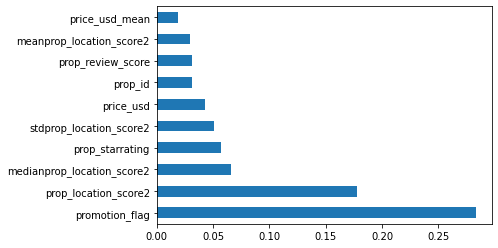

In [31]:
feat_importances = pd.Series(model.feature_importances_, index=X_train_data.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [37]:
def recommend_properties(model, data):
    result = pd.DataFrame(columns=['srch_id', 'prop_id', 'scores'])
    df_list = []
    grouped_data = data.groupby('srch_id')
    for group_name, group in tqdm(grouped_data):
        scores = model.predict(group.loc[:, ~group.columns.isin(['srch_id'])])
        sorted_group = sort_properties(group_name, scores, group['prop_id'])
        df_list.append(sorted_group)
    result = pd.concat(df_list)
    return result

In [38]:
def sort_properties(srch_id, scores, prop_ids):
    sorted_group = pd.DataFrame(columns=['srch_id', 'prop_id', 'scores'])
    sorted_group['srch_id'] = len(scores)*[srch_id]
    sorted_group['prop_id'] = prop_ids.values
    sorted_group['scores'] = scores
    sorted_group = sorted_group.sort_values(by='scores', ascending=False)
    return sorted_group 

In [39]:
start = time.time()
recommendations = recommend_properties(model, preprocessed_test)
end = time.time()
print(f'Total Time for validation prediction:{end - start}')
submission = recommendations.drop(columns=['scores'])
submission.to_csv(f'submission_only_randbool_false.csv', index=False)

100%|█████████████████████████████████████████████████████████| 199549/199549 [1:53:53<00:00, 29.20it/s]


Total Time for validation prediction:6860.928194522858


In [ ]:
def recommend_properties_group(model, group):
    scores = model.predict(group.loc[:, ~group.columns.isin(['srch_id'])])
    sorted_group = sort_properties(group.name, scores, group['prop_id'])
    return sorted_group

In [ ]:
X_val.head()